In [1]:
import json
import random
import sys
import re

sys.path.append('../')

from QAs_generate.tools.llm import ask_question_gpt

# Define file paths
cosql_file_path = 'train_sets/CoSQL_train.json'
qdasql_file_path = 'train_sets/QDASQL_train.json'
results_file_path = 'comparison_results.json'

# Initialize lists to store QA pairs
qa_cosql = []
qa_qdasql = []

# Read CoSQL_train.json file
with open(cosql_file_path, 'r', encoding='utf-8') as f:
    cosql_data = json.load(f)

# Process CoSQL data
for entry in cosql_data:
    turns = entry.get('turns', [])
    for i, turn in enumerate(turns):
        type_field = turn.get('type', '')
        if type_field in ['AMBIGUOUS', 'CANNOT_ANSWER']:
            question = turn.get('text', '')
            if i + 1 < len(turns):
                answer = turns[i + 1].get('text', '')
                qa_cosql.append({'question': question, 'answer': answer})

# Read QDASQL_train.json file
with open(qdasql_file_path, 'r', encoding='utf-8') as f:
    qdasql_data = json.load(f)

# Process QDASQL data
for entry in qdasql_data:
    turns = entry.get('turns', [])
    for i, turn in enumerate(turns):
        type_field = turn.get('type', '')
        if type_field in ['unanswerable', 'ambiguous']:
            question = turn.get('text', '')
            if i + 1 < len(turns):
                answer = turns[i + 1].get('text', '')
                qa_qdasql.append({'question': question, 'answer': answer})

# Print the number of QA pairs collected
print(f"Number of CoSQL QA pairs: {len(qa_cosql)}")
print(f"Number of QDASQL QA pairs: {len(qa_qdasql)}")

# Initialize win/loss/tie counters
wins = 0
losses = 0
ties = 0

# Load existing results
try:
    with open(results_file_path, 'r', encoding='utf-8') as f:
        comparison_results = json.load(f)
except FileNotFoundError:
    comparison_results = []

# Perform 100 random selections
for i in range(0):

    print("============================")
    
    if i % 2 == 0:
        # Even iterations, qa_qdasql goes first
        print("QDA-SQL as first")
        first = qa_qdasql
        second = qa_cosql
        first_label = 'QDA-SQL'
        second_label = 'CoSQL'
    else:
        # Odd iterations, qa_cosql goes first
        print("CoSQL as first")
        first = qa_cosql
        second = qa_qdasql
        first_label = 'CoSQL'
        second_label = 'QDA-SQL'

    # Randomly select one QA pair from each list
    if first and second:  # Ensure both lists are not empty
        selected_first = random.choice(first)
        selected_second = random.choice(second)
        
        # Print the selected QA pairs
        print(f"\nIteration {i + 1}:")
        print(f"QA Pair A - Question: {selected_first['question']}, Answer: {selected_first['answer']}")
        print(f"QA Pair B - Question: {selected_second['question']}, Answer: {selected_second['answer']}")

        prompt = """Please act as an impartial judge and evaluate the quality of the responses provided by two AI assistants to the user question displayed below. You should choose the assistant that follows the user’s instructions and answers the user’s question better. Your evaluation should consider three criteria: Completeness, Relevance, and Utility. Begin your evaluation by comparing the two responses and provide a short explanation. Avoid any position biases and ensure that the order in which the responses were presented does not influence your decision. Do not allow the length of the responses to influence your evaluation. Do not favor certain names of the assistants. Be as objective as possible. After providing your explanation, output your final verdict by strictly following array format: "['A','B','tie']" if assistant A is better in Completeness, B is better in Relevance, and they are tie in Utility."""
        answer = ask_question_gpt(prompt + f"QA Pair A - Question: {selected_first['question']}, Answer: {selected_first['answer']}" + f"QA Pair B - Question: {selected_second['question']}, Answer: {selected_second['answer']}")
        matches = re.findall(r'\[.*?\]', answer)
        result = matches[-1]
        result = result.replace("\'","\"")
        print(result)
        array = json.loads(result)
        print(array)

        # Determine the winner based on the evaluation
        count_a = array.count('A')
        count_b = array.count('B')
        
        if count_a > count_b:
            winner = first_label
            wins += 1 if first_label == 'QDA-SQL' else 0
            losses += 1 if first_label == 'CoSQL' else 0
        elif count_b > count_a:
            winner = second_label
            wins += 1 if second_label == 'QDA-SQL' else 0
            losses += 1 if second_label == 'CoSQL' else 0
        else:
            winner = 'tie'
            ties += 1

        # Store the comparison result with a descriptive evaluation
        evaluation_result = {
            'completeness': first_label if array[0] == 'A' else second_label if array[0] == 'B' else 'tie',
            'relevance': first_label if array[1] == 'A' else second_label if array[1] == 'B' else 'tie',
            'utility': first_label if array[2] == 'A' else second_label if array[2] == 'B' else 'tie'
        }

        comparison_results.append({
            'iteration': i + 1,
            'qa_pair_a': selected_first,
            'qa_pair_b': selected_second,
            'evaluation': evaluation_result,
            'winner': winner,
            'counters': {'wins': wins, 'losses': losses, 'ties': ties}
        })

        # Save updated comparison results to a JSON file
        with open(results_file_path, 'w', encoding='utf-8') as f:
            json.dump(comparison_results, f, ensure_ascii=False, indent=4)

# Print final win/loss/tie results
print(f"Final Results - Win: {wins}, Loss: {losses}, Tie: {ties}")


Number of CoSQL QA pairs: 1185
Number of QDASQL QA pairs: 14582
Final Results - Win: 0, Loss: 0, Tie: 0


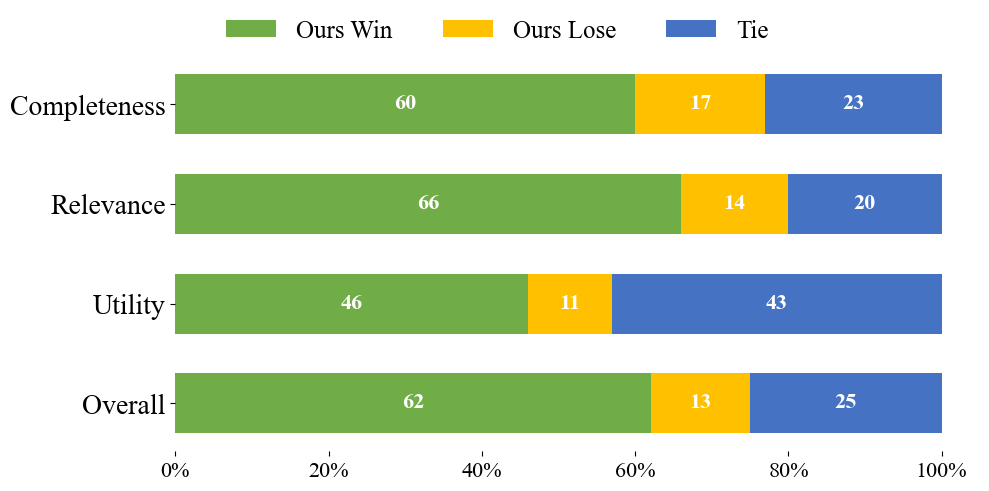

In [44]:
import json
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import PercentFormatter

# Load the comparison results
with open('train_sets/comparison_results.json', 'r', encoding='utf-8') as f:
    comparison_results = json.load(f)

# Initialize counters
completeness = {'wins': 0, 'losses': 0, 'ties': 0}
relevance = {'wins': 0, 'losses': 0, 'ties': 0}
utility = {'wins': 0, 'losses': 0, 'ties': 0}
overall = {'wins': 0, 'losses': 0, 'ties': 0}

# Count the results
for result in comparison_results:
    evaluation = result['evaluation']
    winner = result['winner']

    for criterion in ['completeness', 'relevance', 'utility']:
        if evaluation[criterion] == 'QDA-SQL':
            if criterion == 'completeness':
                completeness['wins'] += 1
            elif criterion == 'relevance':
                relevance['wins'] += 1
            elif criterion == 'utility':
                utility['wins'] += 1
        elif evaluation[criterion] == 'CoSQL':
            if criterion == 'completeness':
                completeness['losses'] += 1
            elif criterion == 'relevance':
                relevance['losses'] += 1
            elif criterion == 'utility':
                utility['losses'] += 1
        else:
            if criterion == 'completeness':
                completeness['ties'] += 1
            elif criterion == 'relevance':
                relevance['ties'] += 1
            elif criterion == 'utility':
                utility['ties'] += 1

    if winner == 'QDA-SQL':
        overall['wins'] += 1
    elif winner == 'CoSQL':
        overall['losses'] += 1
    else:
        overall['ties'] += 1

# Prepare data for plotting
categories = ['Overall', 'Utility', 'Relevance', 'Completeness']
wins = [overall['wins'], utility['wins'], relevance['wins'], completeness['wins']]
losses = [overall['losses'], utility['losses'], relevance['losses'], completeness['losses']]
ties = [overall['ties'], utility['ties'], relevance['ties'], completeness['ties']]

# Create the plot
fig, ax = plt.subplots(figsize=(10, 5))

bar_width = 0.6  # Adjusted bar width for a more compact look
r = np.arange(len(categories))

# Set bar colors
win_color = '#70AD47'  # Green
lose_color = '#FFC000'  # Orange
tie_color = '#4672C4'   # Blue

# Create bars without edge color
ax.barh(r, wins, color=win_color, height=bar_width, label='Ours Win')
ax.barh(r, losses, left=wins, color=lose_color, height=bar_width, label='Ours Lose')
ax.barh(r, ties, left=np.add(wins, losses), color=tie_color, height=bar_width, label='Tie')

# Add labels
ax.set_yticks(r)
ax.set_yticklabels(categories, fontsize=20)

# Set x-axis to percentage format
ax.xaxis.set_major_formatter(PercentFormatter(xmax=100))  # Assuming the maximum value is 100

# Increase x-axis tick label font size
ax.tick_params(axis='x', labelsize=16)

# Move the legend above the plot, independent of the plot area
ax.legend(fontsize=18, loc='upper center', bbox_to_anchor=(0.4, 1.15), ncol=3, frameon=False)

# Add text labels
for i, (w, l, t) in enumerate(zip(wins, losses, ties)):
    ax.text(w / 2, i, str(w), va='center', ha='center', color='white', fontweight='bold', fontsize=16)
    ax.text(w + l / 2, i, str(l), va='center', ha='center', color='white', fontweight='bold', fontsize=16)
    ax.text(w + l + t / 2, i, str(t), va='center', ha='center', color='white', fontweight='bold', fontsize=16)

# Set font to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

# Remove the outer border
for spine in ax.spines.values():
    spine.set_visible(False)

# Save the figure as a PDF
plt.tight_layout()
plt.savefig('train_sets/comparison_results.pdf', format='pdf', bbox_inches='tight')  # Save as PDF
plt.show()
